## Importing Libraries 

In [66]:
import numpy as np
import pandas as pd 

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup

from os import walk
from os.path import join

import matplotlib.pyplot as plt 
from wordcloud import WordCloud
from PIL import Image
import seaborn as sns

#Other 
%matplotlib inline
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shubhamghag/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shubhamghag/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Constants

In [62]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'


SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

LIKE_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
UNLIKE_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

## Reading Files 

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False 
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)





Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

## Generator Function

In [5]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [6]:
for i in generate_squares(5):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 

## Email Body Extraction

In [7]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False 
            lines = []
            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body 

        

In [8]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [9]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH,SPAM_CAT))
spam_emails.head()

,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


In [10]:
spam_emails.shape

(1898, 2)

In [11]:
non_spam_emails = df_from_directory(EASY_NONSPAM_1_PATH,HAM_CAT)
non_spam_emails = non_spam_emails.append(df_from_directory(EASY_NONSPAM_2_PATH,HAM_CAT))
non_spam_emails.head()

,MESSAGE,CATEGORY
00769.25bf9a767b5db0ed93f03c1637281663,"\n\nIn a message dated 9/24/2002 11:24:58 AM, ...",0
01074.8590d61ac0aeeadb58dc2f2ba776c406,"Hiya, I always seem to get errors when I do an...",0
02479.14365bcad3a60fcf24c5c1813f6291fb,\n\nI don't know how one can expect better and...,0
01417.ce7b07a2114218dbac682b599785820d,Tim Peters wrote:\n\n> I've run no experiments...,0
00357.d559b71616f64ba1d1c1e61a03644fd4,"At 10:34 AM -0700 on 8/28/02, Jim Whitehead wr...",0


In [12]:
non_spam_emails.shape

(3901, 2)

In [13]:
df = pd.concat([spam_emails, non_spam_emails])
print("Shape of the entire dataframe is:", df.shape)
df.head()

Shape of the entire dataframe is: (5799, 2)


,MESSAGE,CATEGORY
00249.5f45607c1bffe89f60ba1ec9f878039a,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1
00373.ebe8670ac56b04125c25100a36ab0510,ATTENTION: This is a MUST for ALL Computer Use...,1
00214.1367039e50dc6b7adb0f2aa8aba83216,This is a multi-part message in MIME format.\n...,1
00210.050ffd105bd4e006771ee63cabc59978,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1
00033.9babb58d9298daa2963d4f514193d7d6,This is the bottom line. If you can GIVE AWAY...,1


## Data Cleaning 

In [14]:
df['MESSAGE'].isnull().sum()

0

In [15]:
(df.MESSAGE.str.len() == 0).sum()

3

In [16]:
df[df.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [17]:
df.drop(['cmds'], inplace=True)

In [18]:
(df.MESSAGE.str.len() == 0).sum()

0

In [19]:
df.shape

(5796, 2)

## Adding Document IDs to Track Emails in DF 

In [20]:
doc_ids = range(0, len(df.index))
df['DOC_IDS'] = doc_ids

In [21]:
df['FILE_NAME'] = df.index
df.set_index('DOC_IDS', inplace = True)
df.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_IDS,,,
0,"Dear Homeowner,\n\n \n\nInterest Rates are at ...",1,00249.5f45607c1bffe89f60ba1ec9f878039a
1,ATTENTION: This is a MUST for ALL Computer Use...,1,00373.ebe8670ac56b04125c25100a36ab0510
2,This is a multi-part message in MIME format.\n...,1,00214.1367039e50dc6b7adb0f2aa8aba83216
3,IMPORTANT INFORMATION:\n\n\n\nThe new domain n...,1,00210.050ffd105bd4e006771ee63cabc59978
4,This is the bottom line. If you can GIVE AWAY...,1,00033.9babb58d9298daa2963d4f514193d7d6


In [22]:
df.to_json(DATA_JSON_FILE)

## EDA

In [23]:
df.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [24]:
total_spam = df.CATEGORY.value_counts()[1]
total_non_spam = df.CATEGORY.value_counts()[0]

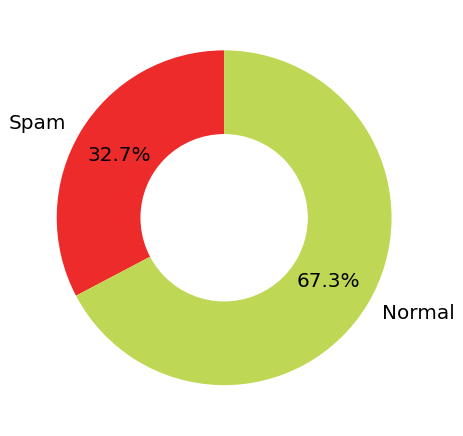

In [25]:
category_names = ['Spam', 'Normal']
sizes = [total_spam,total_non_spam]

custom_colors = ['#ED2B2A', '#BED754']

plt.figure(figsize=(6,8),dpi=90)
plt.pie(sizes, labels=category_names, textprops={'fontsize':16},startangle=90
    ,autopct='%1.1f%%', colors=custom_colors,pctdistance=0.73)

centre_circle = plt.Circle((0,0),radius=0.5,fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

## Preprocessing the data for analysis
### Word Stemming 

In [26]:
stemmer = PorterStemmer()

In [27]:
soup = BeautifulSoup(df.at[2,'MESSAGE'], 'html.parser')
print(soup.get_text())

This is a multi-part message in MIME format.



------=_NextPart_000_1CDC19_01C25366.4B57F3A0

Content-Type: text/plain;

	charset="Windows-1252"

Content-Transfer-Encoding: quoted-printable



 We dare you...

 Try to find a better annuity!

=20

  - 5.40% Guaranteed for 6 Years=0A=

- 6 Year Surrender Charge=0A=

- 5% Agent

Commission up to age 80=09

Call today for more information!

 800-888-7641 ext. 103

- or -



Please fill out the form below for more information	=20

Name:	 	  =09

E-mail:	 	=20

Phone:	 	=20

City:	 	 State:	 	=20

 	    =09

=20

 PMG Financial Services

*5.40% for deposits of $100,000 and up, 5.25% interest for deposits

totalling $25,000-$99,999.	=20

We don't want anyone to receive our mailings who does not wish to

receive them. This is a professional communication sent to insurance

professionals. To be removed from this mailing list, DO NOT REPLY to

this message. Instead, go here: http://www.insuranceiq.com/optout

=20



Legal Notice =20



------=_

In [53]:
def clean_emails(email,stemmer=PorterStemmer()
                ,stop_words=set(stopwords.words('english'))):
    soup = BeautifulSoup(email,'html.parser')
    cleaned = soup.get_text()
    
    words = word_tokenize(cleaned.lower())
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
            #filtered_words.append(word)
    return filtered_words

In [29]:
clean_emails(df.at[2,'MESSAGE'])

['message',
 'mime',
 'format',
 'dare',
 'try',
 'find',
 'better',
 'annuity',
 'guaranteed',
 'year',
 'surrender',
 'agent',
 'commission',
 'age',
 'call',
 'today',
 'information',
 'ext',
 'please',
 'fill',
 'form',
 'information',
 'name',
 'phone',
 'city',
 'state',
 'pmg',
 'financial',
 'services',
 'deposits',
 'interest',
 'deposits',
 'totalling',
 'want',
 'anyone',
 'receive',
 'mailings',
 'wish',
 'receive',
 'professional',
 'communication',
 'sent',
 'insurance',
 'professionals',
 'removed',
 'mailing',
 'list',
 'reply',
 'message',
 'instead',
 'go',
 'http',
 'legal',
 'notice',
 'dare',
 'find',
 'better',
 'annuity',
 'call',
 'today',
 'information',
 'please',
 'fill',
 'form',
 'information',
 'name',
 'phone',
 'city',
 'state',
 'deposits',
 'interest',
 'deposits',
 'totalling',
 'want',
 'anyone',
 'receive',
 'mailings',
 'wish',
 'receive',
 'professional',
 'sent',
 'insurance',
 'professionals',
 'removed',
 'list',
 'reply',
 'message',
 'instead

In [30]:
%%time

nested_list = df.MESSAGE.apply(clean_emails)

/var/folders/dw/g0x_cwzj4l97vv535grtx42w0000gn/T/ipykernel_3985/4291883557.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(email,'html.parser')
/var/folders/dw/g0x_cwzj4l97vv535grtx42w0000gn/T/ipykernel_3985/4291883557.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(email,'html.parser')


CPU times: user 14.3 s, sys: 69.5 ms, total: 14.4 s
Wall time: 14.4 s


In [31]:
nested_list.head()

DOC_IDS
0    [dear, homeowner, interest, rates, lowest, poi...
1    [attention, must, computer, users, package, de...
2    [message, mime, format, dare, try, find, bette...
3    [important, information, new, domain, names, f...
4    [bottom, line, give, away, cd, free, people, l...
Name: MESSAGE, dtype: object

In [32]:
nested_list.tail()

DOC_IDS
5791    [one, working, well, week, tes, updates, serve...
5792    [damien, morton, quoted, approves, html, able,...
5793    [mon, che, wrote, thats, correct, lines, added...
5794    [upon, time, manfred, wrote, would, like, inst...
5795    [run, pick, use, new, ftoc, button, show, mess...
Name: MESSAGE, dtype: object

In [33]:
doc_ids_spam = df[df.CATEGORY == 1].index
doc_ids_normal = df[df.CATEGORY == 0].index

doc_ids_normal

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_IDS', length=3900)

In [34]:
nested_list_normal = nested_list.loc[doc_ids_normal]
nested_list_normal.head()

DOC_IDS
1896    [message, dated, jamesr, writes, situation, wo...
1897    [hiya, always, seem, get, errors, apt, update,...
1898    [know, one, expect, better, secure, code, comm...
1899    [tim, peters, wrote, run, experiments, trainin...
1900    [jim, whitehead, wrote, great, half, need, bec...
Name: MESSAGE, dtype: object

In [35]:
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_spam.head()

DOC_IDS
0    [dear, homeowner, interest, rates, lowest, poi...
1    [attention, must, computer, users, package, de...
2    [message, mime, format, dare, try, find, bette...
3    [important, information, new, domain, names, f...
4    [bottom, line, give, away, cd, free, people, l...
Name: MESSAGE, dtype: object

In [36]:
flat_list_normal = [item for sublist in nested_list_normal for item in sublist]
normal_words = pd.Series(flat_list_normal)
unique_words = pd.Series(flat_list_normal).value_counts()

print('Total number of words in normal emails:', normal_words.shape[0])
print('Total number of unique words in normal emails:', unique_words.shape[0])

Total number of words in normal emails: 442056
Total number of unique words in normal emails: 30098


In [37]:
print('Most Common words:',unique_words[:10])

Most Common words: http      6609
list      2662
one       2247
would     2003
get       1780
like      1729
use       1704
wrote     1679
new       1500
people    1458
dtype: int64


In [38]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam)
unique_words = pd.Series(flat_list_spam).value_counts()

print('Total number of words in spam emails:', spam_words.shape[0])
print('Total number of unique words in spam emails:', unique_words.shape[0])

Total number of words in spam emails: 317502
Total number of unique words in spam emails: 18022


In [39]:
print('Most Common words:',unique_words[:10])

Most Common words: http        2902
email       2775
free        2583
click       1945
please      1824
get         1710
business    1635
list        1549
money       1541
one         1504
dtype: int64


### Word Clouds

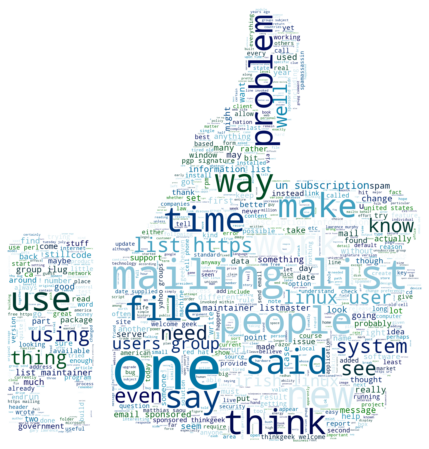

CPU times: user 14.4 s, sys: 267 ms, total: 14.6 s
Wall time: 14.1 s


In [50]:
%%time

img = Image.open(LIKE_FILE)
img_mask = Image.new(mode='RGB', size=img.size, color=(255, 255, 255))
img_mask.paste(img, box=img)

rgb_array = np.array(img_mask)

# Assuming flat_list_normal is a pre-processed list of words
normal_str = ' '.join(flat_list_normal)

# You can adjust the max_words parameter here to a suitable value
word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=1000, colormap='ocean')

# The generate function may still raise an error if normal_str is too long
try:
    word_cloud.generate(normal_str)
except ValueError as e:
    print("String too long, try reducing the number of words or splitting the string")

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

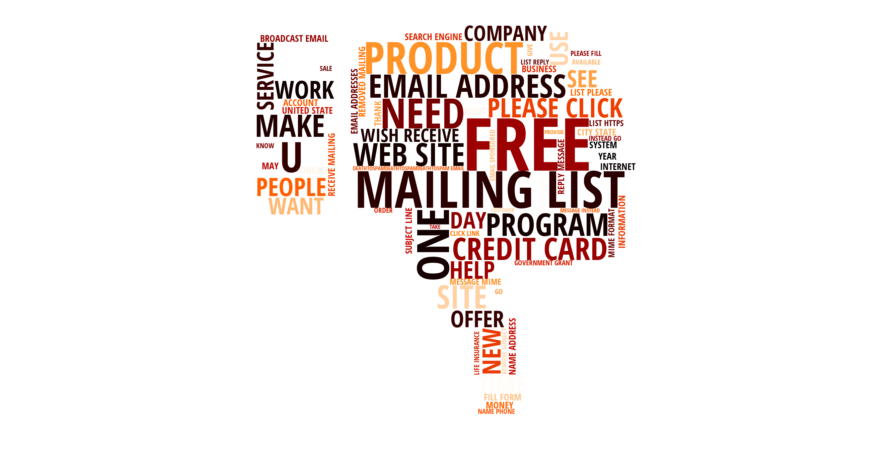

CPU times: user 6.16 s, sys: 176 ms, total: 6.34 s
Wall time: 5.81 s


In [51]:
%%time

img = Image.open(UNLIKE_FILE)
img_mask = Image.new(mode='RGB', size=img.size, color=(255, 255, 255))
img_mask.paste(img, box=img)

rgb_array = np.array(img_mask)

# Assuming flat_list_normal is a pre-processed list of words
spam_str = ' '.join(flat_list_spam)

# You can adjust the max_words parameter here to a suitable value
word_cloud = WordCloud(mask=rgb_array, background_color='white',
                      max_words=2000, colormap='gist_heat',font_path=CUSTOM_FONT_FILE)

# The generate function may still raise an error if normal_str is too long
try:
    word_cloud.generate(spam_str.upper())
except ValueError as e:
    print("String too long, try reducing the number of words or splitting the string")

plt.figure(figsize=[16,8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [54]:
stemmed_nested_list = df.MESSAGE.apply(clean_emails)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/var/folders/dw/g0x_cwzj4l97vv535grtx42w0000gn/T/ipykernel_3985/2575873531.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(email,'html.parser')
/var/folders/dw/g0x_cwzj4l97vv535grtx42w0000gn/T/ipykernel_3985/2575873531.py:3: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(email,'html.parser')


In [56]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Number of unique words', unique_words.shape[0])
unique_words.head()

Number of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [59]:
frequent_words = unique_words[0:VOCAB_SIZE]
print("Most common words: \n", frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


In [63]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


In [65]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

In [71]:
df_word_columns = pd.DataFrame.from_records(stemmed_nested_list.tolist())
df_word_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,dear,homeown,interest,rate,lowest,point,year,help,find,best,...,None,None,None,None,None,None,None,None,None,None
1,attent,must,comput,user,packag,deal,norton,systemwork,softwar,suit,...,None,None,None,None,None,None,None,None,None,None
2,messag,mime,format,dare,tri,find,better,annuiti,guarante,year,...,None,None,None,None,None,None,None,None,None,None
3,import,inform,new,domain,name,final,avail,gener,public,discount,...,None,None,None,None,None,None,None,None,None,None
4,bottom,line,give,away,cd,free,peopl,like,one,month,...,None,None,None,None,None,None,None,None,None,None


## Train-Test split

In [74]:
X_train, X_test, y_train, y_test = train_test_split(df_word_columns, df.CATEGORY,
                                                   test_size=0.3, random_state=42)

In [82]:
print("Number of training samples", X_train.shape[0])
print("Percentage of training set", np.round((X_train.shape[0] / df_word_columns.shape[0]) * 100),"%")

Number of training samples 4057
Percentage of training set 70.0 %


In [83]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,thu,jul,rodent,unusu,size,wrote,appli,one,three,order,...,None,None,None,None,None,None,None,None,None,None
4727,well,would,vaniti,list,forward,least,littl,pure,data,week,...,None,None,None,None,None,None,None,None,None,None
5022,world,wide,word,issu,saturday,august,sent,saturday,subscrib,least,...,None,None,None,None,None,None,None,None,None,None
3504,believ,spamassassin,maintain,scheme,wherebi,corpu,distribut,ie,sever,peopl,...,None,None,None,None,None,None,None,None,None,None
3921,sorri,think,send,realiz,list,sender,usual,anyawi,ask,harri,...,None,None,None,None,None,None,None,None,None,None
